In [133]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import shapiro
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder, PowerTransformer
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score,\
f1_score, confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay
import pickle
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, accuracy_score

from xgboost import XGBClassifier
from xgboost import plot_importance
from sklearn import metrics
from sklearn.linear_model import LogisticRegression, LinearRegression, Ridge, Lasso
from sklearn.preprocessing import LabelEncoder


#show warnings at each run:
import warnings
warnings.filterwarnings('always')  # "error", "ignore", "always", "default", "module" or "once"

In [98]:
my_palette = {'#4CC9F0','#3A0CA3'} #, '#F72585', '#7209B7'}


In [128]:
original_df = pd.read_csv("restaurant_customer_satisfaction.csv") 

### Exploratory Data Analysis (EDA)

In [ ]:
df = original_df.copy()

In [4]:
# df.head(2)
# df.describe()
# df.info()
# df.isnull().sum() #looking for missing values

In [5]:
# Check for duplicates
print(f"Number of duplicates: {df.duplicated().sum()}")
df.drop_duplicates(inplace=True)
print(f"Number of duplicates: {df.duplicated().sum()}")

Number of duplicates: 0
Number of duplicates: 0


0    0.866
1    0.134
Name: HighSatisfaction, dtype: float64


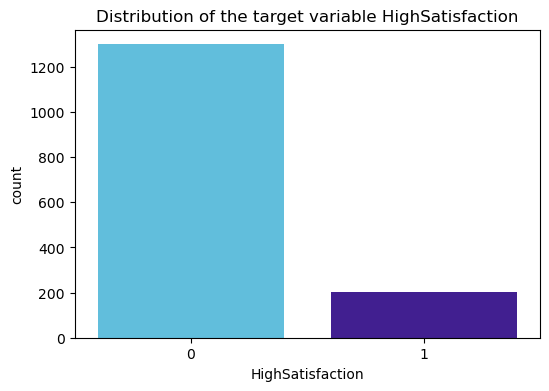

In [6]:
# Distribution of the target variable
print(df['HighSatisfaction'].value_counts(normalize=True))
plt.figure(figsize=(6, 4))

sns.set_palette(my_palette)


sns.countplot(x=df['HighSatisfaction'])

plt.title('Distribution of the target variable HighSatisfaction')
plt.show()


In [7]:
numeric_columns = ['Age', 'Income', 'AverageSpend', 'WaitTime', 'ServiceRating', 
                   'FoodRating', 'AmbianceRating']

categorical_columns = ['Gender', 'PreferredCuisine', 'DiningOccasion', 'MealType', 
                       'OnlineReservation', 'DeliveryOrder', 'LoyaltyProgramMember']

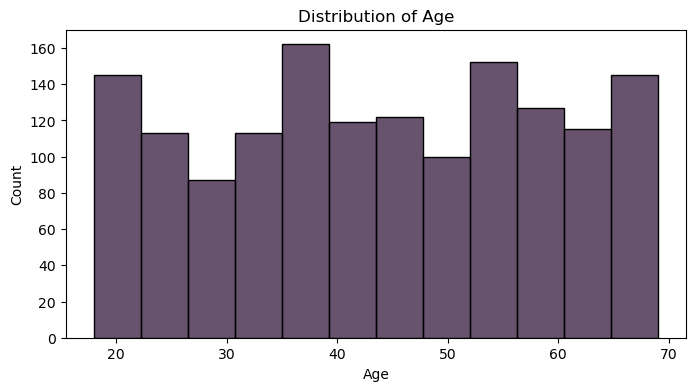

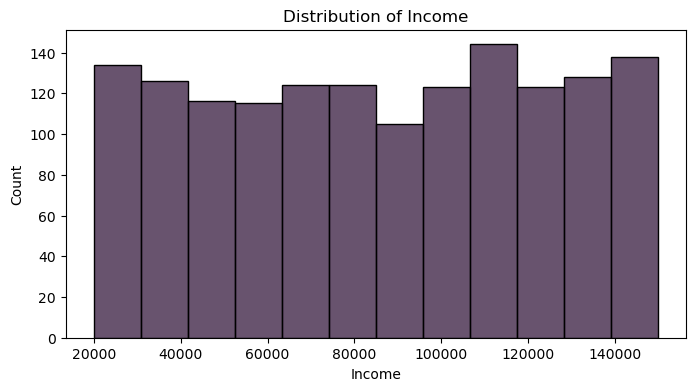

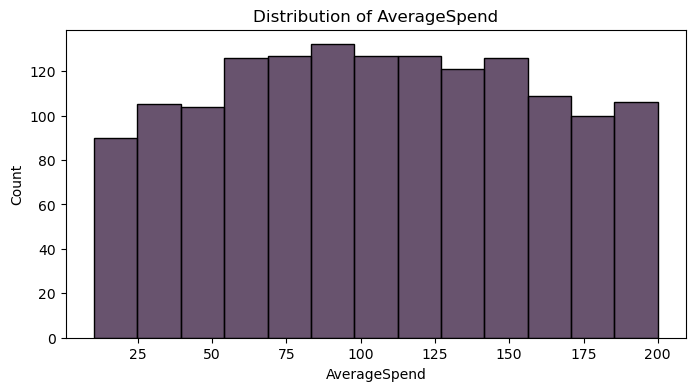

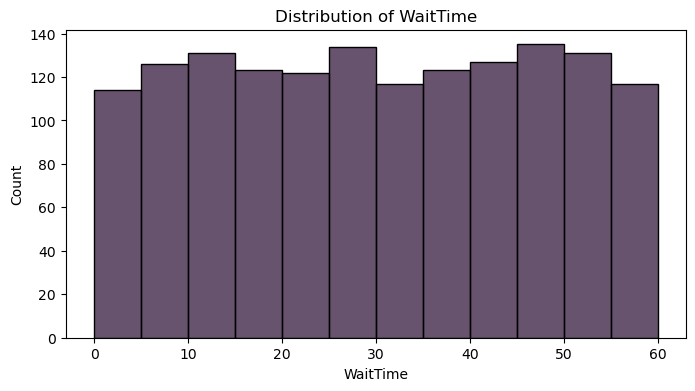

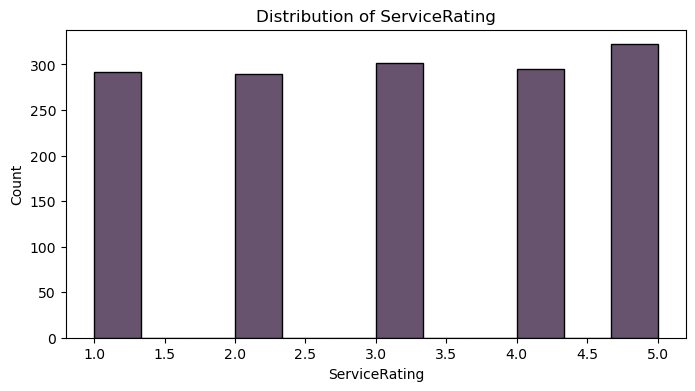

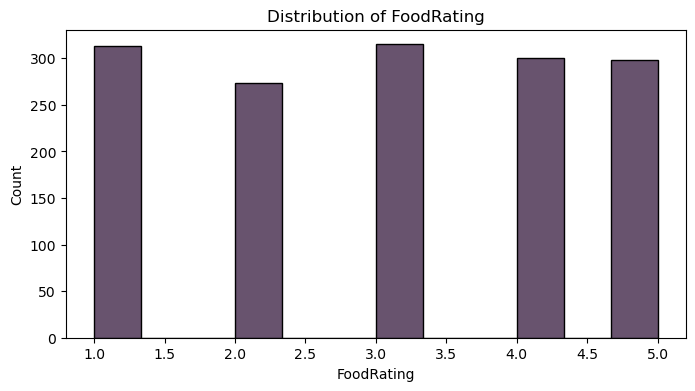

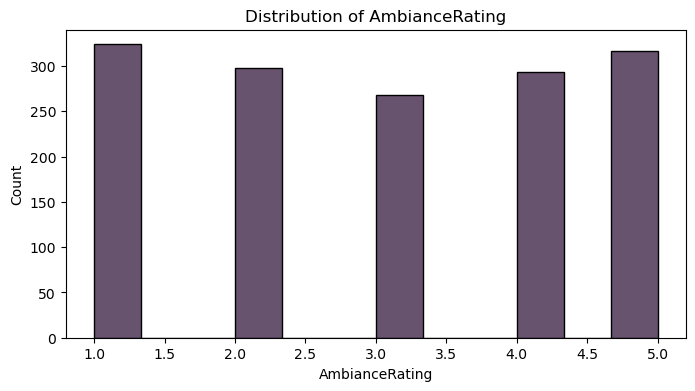

In [8]:
# Plot distributions for numerical features
sns.set_palette("rocket")

for column in numeric_columns:
    plt.figure(figsize=(8, 4))
    
    sns.histplot(df[column].dropna(), kde=False)
    plt.title(f'Distribution of {column}')
    plt.show()

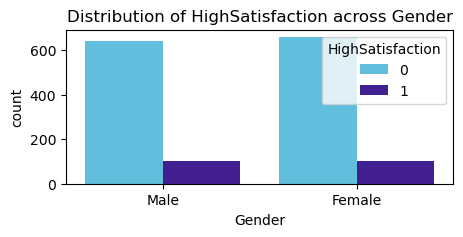

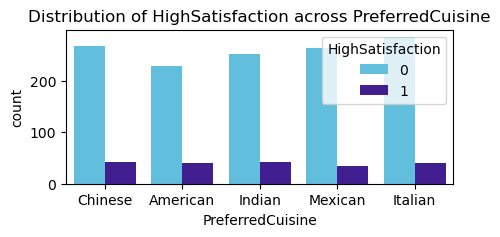

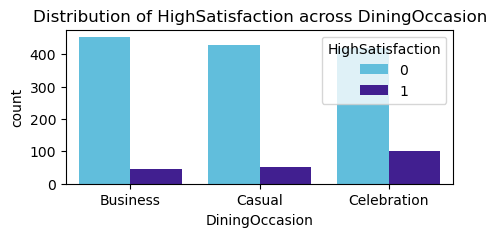

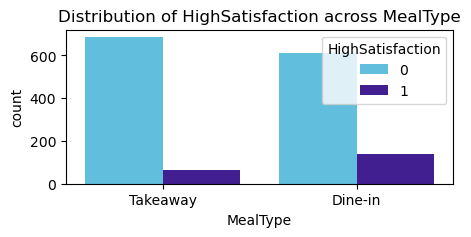

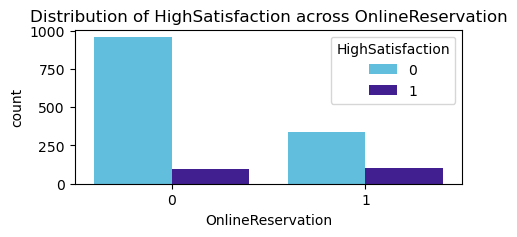

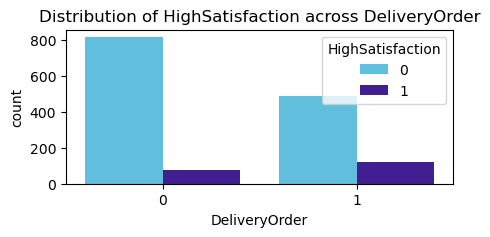

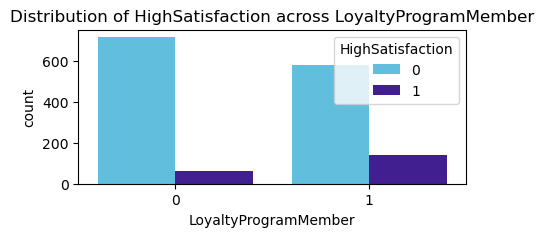

In [9]:
# Distribution of HighSatisfaction over different categorical features
sns.set_palette(my_palette)

for column in categorical_columns:
    plt.figure(figsize=(5, 2))
    sns.countplot(x=column, hue='HighSatisfaction', data=df)
    plt.title(f'Distribution of HighSatisfaction across {column}')
    plt.show()

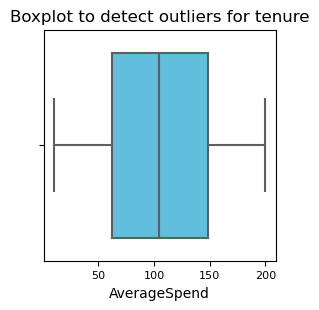

In [10]:
### Check outliers
plt.figure(figsize=(3,3))
plt.title('Boxplot to detect outliers for tenure', fontsize=12)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
sns.boxplot(x=df['AverageSpend']) #Age', 'Income', 'AverageSpend', 'GroupSize'
plt.show()

In [11]:
#check for normality for logistic regression. 

### Feature Engineering

In [12]:
# Feature selection. CustomerID has no predictive value.
df = df.drop(['CustomerID'], axis=1) 

In [13]:
# Creating new features
df['Income_Per_Age'] = df['Income'] / df['Age']
#df['Spend_Per_Visit'] = df['AverageSpend'] / df['VisitFrequency'].map({'Rarely': 1, 'Monthly': 4, 'Weekly': 12, 'Daily': 90})
#df['VisitFrequency_numeric']=df['VisitFrequency'].map({'Rarely': 1, 'Monthly': 4, 'Weekly': 12, 'Daily': 90})

In [14]:
# Update the numeric columns list
numeric_columns.extend(['Income_Per_Age'])#, 'Spend_Per_Visit'])

In [15]:
#check again for missing values:
#df.isnull().sum()
#df[['AverageSpend','VisitFrequency','VisitFrequency_numeric','Spend_Per_Visit']].sort_values('Spend_Per_Visit')

In [16]:
### Feature transformation
# Dummy encode categorical variables to prepare for modeling:
df2 = pd.get_dummies(df, drop_first='True')

### Split the data

In [41]:
# Define the y (target) variable
y = df2["HighSatisfaction"]

# Define the X (predictor) variables
X = df2.copy()
X = X.drop("HighSatisfaction", axis = 1)

# Split into train and test sets 
#(using stratify because of the imbalanced dataset. We will preserve this ratio when we model.)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y, random_state=42)

# Classifers

## 1. RandomForestClassifier

In [42]:
%%time

rf = RandomForestClassifier(random_state = 0)

cv_params = {'max_depth': [2,3,4,5], 
             'min_samples_leaf': [1,2,3],
             'min_samples_split': [2,3,4],
             'max_features': [5, 10, 15, 20],
             'n_estimators': [75, 100, 125, 150]
             }  

scoring = {'accuracy', 'precision', 'recall', 'f1'}

rf_cv = GridSearchCV(rf, cv_params, scoring=scoring, cv=5, refit='accuracy')


CPU times: user 77 µs, sys: 1 µs, total: 78 µs
Wall time: 83 µs


In [43]:
#rf_cv.fit(X_train, y_train) 

In [44]:
print('done')

done


In [45]:
# Pickle the model
#with open('rf_cv_model.pickle', 'wb') as to_write:
#    pickle.dump(rf_cv, to_write)

In [46]:
# Read in pickled model
with open('rf_cv_model.pickle', 'rb') as to_read:
    rf_cv = pickle.load(to_read)

In [47]:
rf_cv.best_params_

{'max_depth': 5,
 'max_features': 20,
 'min_samples_leaf': 3,
 'min_samples_split': 2,
 'n_estimators': 100}

In [48]:
rf_cv.best_score_

0.8764444444444445

In [49]:
rf_cv.cv_results_.keys()

dict_keys(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'param_max_depth', 'param_max_features', 'param_min_samples_leaf', 'param_min_samples_split', 'param_n_estimators', 'params', 'split0_test_precision', 'split1_test_precision', 'split2_test_precision', 'split3_test_precision', 'split4_test_precision', 'mean_test_precision', 'std_test_precision', 'rank_test_precision', 'split0_test_f1', 'split1_test_f1', 'split2_test_f1', 'split3_test_f1', 'split4_test_f1', 'mean_test_f1', 'std_test_f1', 'rank_test_f1', 'split0_test_recall', 'split1_test_recall', 'split2_test_recall', 'split3_test_recall', 'split4_test_recall', 'mean_test_recall', 'std_test_recall', 'rank_test_recall', 'split0_test_accuracy', 'split1_test_accuracy', 'split2_test_accuracy', 'split3_test_accuracy', 'split4_test_accuracy', 'mean_test_accuracy', 'std_test_accuracy', 'rank_test_accuracy'])

In [50]:
rf_cv.cv_results_.get('mean_test_accuracy').max()

0.8764444444444445

In [51]:
best_model = rf_cv.best_estimator_
best_model.fit(X_train, y_train)

RandomForestClassifier(max_depth=5, max_features=20, min_samples_leaf=3,
                       random_state=0)

#### Model Evaluation

In [52]:
# Model evaluation
y_pred = best_model.predict(X_test)
print(classification_report(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.88      1.00      0.93       325
           1       1.00      0.08      0.15        50

    accuracy                           0.88       375
   macro avg       0.94      0.54      0.54       375
weighted avg       0.89      0.88      0.83       375

Accuracy: 0.8773333333333333


In [53]:
# Encode the target variable
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

In [54]:
label_encoder.classes_

array([0, 1])

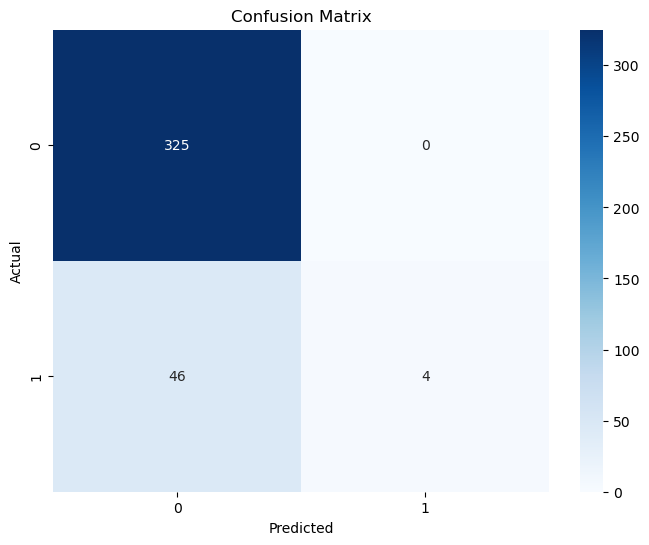

In [56]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

## 2. XGBoost 

In [19]:
xgb = XGBClassifier(objective='binary:logistic', random_state=0)

In [20]:
#Define parameters for tuning.
cv_params = {'max_depth': [4, 6],
              'min_child_weight': [3, 5],
              'learning_rate': [0.1, 0.2, 0.3],
              'n_estimators': [5,10,15],
              'subsample': [0.7],
              'colsample_bytree': [0.7]
              }

In [21]:
scoring = {'accuracy', 'precision', 'recall', 'f1'}

xgb_cv = GridSearchCV(xgb,
                      cv_params,
                      scoring = scoring,
                      cv = 5,
                      refit = 'accuracy'
                     )

In [22]:
#xgb_cv = xgb_cv.fit(X_train, y_train)
#xgb_cv

/Users/talinm/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/talinm/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/talinm/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/talinm/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:

/Users/talinm/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/talinm/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/talinm/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/talinm/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:

/Users/talinm/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/talinm/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/talinm/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/talinm/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=0, ...),
             param_grid={'colsample_bytree': [0.7],
                         'learning_rate': [0.1, 0.2, 0.3], 'max_depth': [4, 6],
                         'min_child_weight': [3, 5],
                         'n_estimators': [5, 10, 15], 'subsample': [0.7]},
             refit='accuracy',
             scoring={'precision', 'f1', 'accuracy', 'recall'})

In [ ]:
# Pickle the model
#with open('xgb_cv.pickle', 'wb') as to_write:
#    pickle.dump(xgb_cv, to_write)

In [60]:
# Read in pickled model
with open('xgb_cv.pickle', 'rb') as to_read:
    xgb_cv = pickle.load(to_read)

In [61]:
xgb_cv.best_params_

{'colsample_bytree': 0.7,
 'learning_rate': 0.3,
 'max_depth': 6,
 'min_child_weight': 3,
 'n_estimators': 15,
 'subsample': 0.7}

In [74]:

cv_params = {'max_depth': [4, 6],
              'min_child_weight': [3, 5],
              'learning_rate': [0.1, 0.2, 0.3],
              'n_estimators': [5,10,15],
              'subsample': [0.7],
              'colsample_bytree': [0.7]
            }

In [63]:
xgb_cv.best_score_

0.8933333333333333

In [64]:
y_pred = xgb_cv.predict(X_test)

In [65]:
ac_score = metrics.accuracy_score(y_test, y_pred)
print('accuracy score:', ac_score)

pc_score = metrics.precision_score(y_test, y_pred)
print('precision score:', pc_score)

rc_score = metrics.recall_score(y_test, y_pred)
print('recall score:', rc_score)

f1_score = metrics.f1_score(y_test, y_pred)
print('f1 score:', f1_score)

accuracy score: 0.904
precision score: 0.85
recall score: 0.34
f1 score: 0.4857142857142858


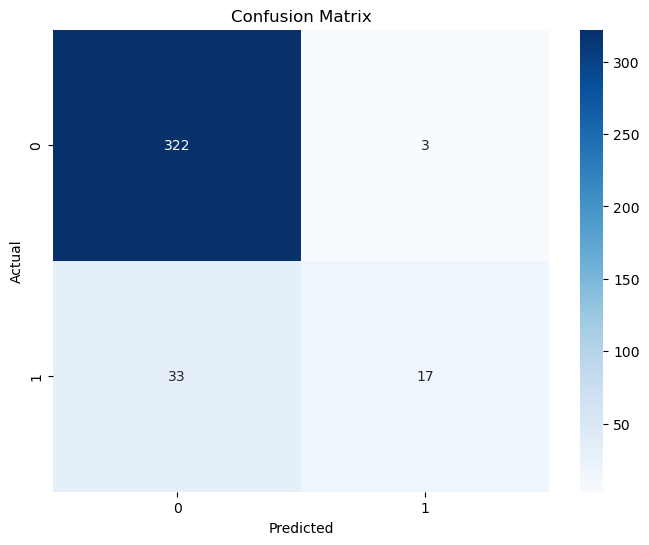

In [66]:
# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=xgb_cv.classes_, yticklabels=xgb_cv.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

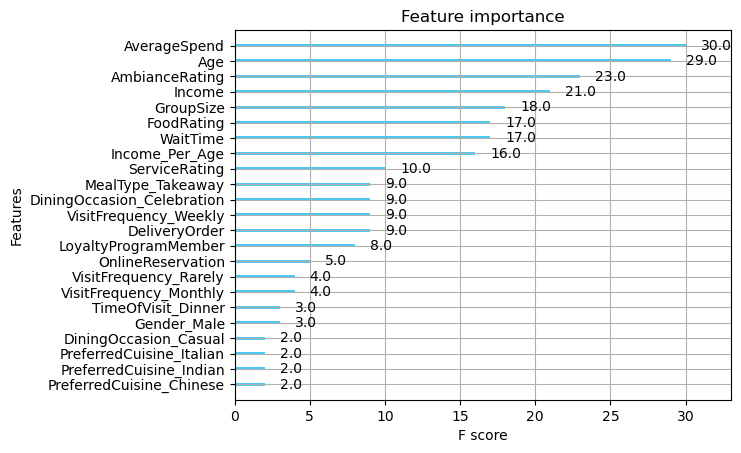

In [67]:
plot_importance(xgb_cv.best_estimator_)

## 3. GradientBoostingClassifier from sklearn

In [69]:
model_gbc=GradientBoostingClassifier(n_estimators=500,learning_rate=0.05,random_state=42,max_features=5 )

In [70]:
model_gbc.fit(X_train,y_train)
y_prediction = model_gbc.predict(X_test)
roc_auc = roc_auc_score(y_test, y_prediction)

In [71]:
roc_auc

0.6746153846153845

In [72]:
classification_report(y_test,y_prediction,digits=5)

'              precision    recall  f1-score   support\n\n           0    0.91040   0.96923   0.93890       325\n           1    0.65517   0.38000   0.48101        50\n\n    accuracy                        0.89067       375\n   macro avg    0.78279   0.67462   0.70995       375\nweighted avg    0.87637   0.89067   0.87785       375\n'

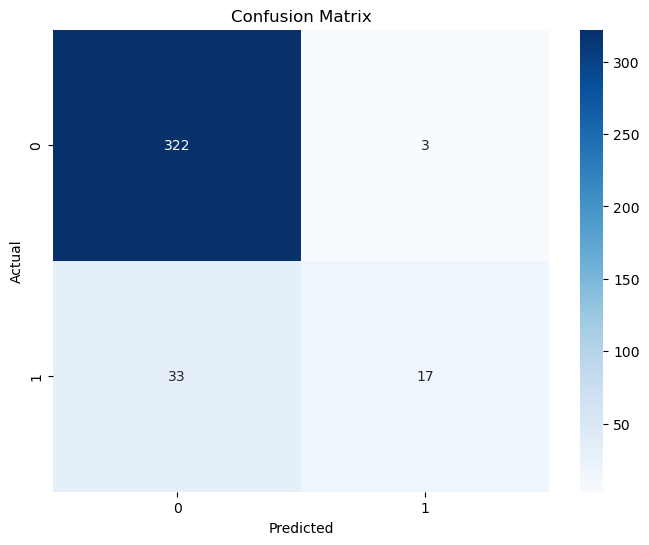

In [68]:
# Confusion matrix
# cm = metrics.confusion_matrix(y_test, y_pred)
# disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model_gbc.classes_)
# disp.plot()
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=xgb_cv.classes_, yticklabels=xgb_cv.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

## 4. Logistic Regression

In [153]:
df3 = original_df.copy()

gender_label = LabelEncoder()
freq_label = LabelEncoder()
cuisine_label = LabelEncoder()
time_label = LabelEncoder()
occa_label = LabelEncoder()
meal_label = LabelEncoder()

df3['Gender'] = gender_label.fit_transform(df['Gender'])
df3['VisitFrequency'] = freq_label.fit_transform(df['VisitFrequency'])
df3['PreferredCuisine'] = cuisine_label.fit_transform(df['PreferredCuisine'])
df3['TimeOfVisit'] = time_label.fit_transform(df['TimeOfVisit'])
df3['DiningOccasion'] = occa_label.fit_transform(df['DiningOccasion'])
df3['MealType'] = meal_label.fit_transform(df['MealType'])

In [164]:
X = df3.drop(labels=['HighSatisfaction'],axis=1)
Y = df3['HighSatisfaction']

X_train, X_test, Y_train, Y_test = train_test_split(X,Y,test_size=0.25, random_state=42)
clf = LogisticRegression() #LogisticRegression(max_iter=200)
clf.fit(X_train,Y_train)
clf.score(X_test,Y_test)

/Users/talinm/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.872

In [165]:
clf.coef_

array([[ 1.25235678e-04, -9.10039841e-03, -7.56058858e-04,
        -2.74784655e-06,  1.10449459e-03, -1.31806361e-03,
        -4.30264359e-03, -2.59490871e-03, -1.45592932e-02,
         1.79303956e-03, -3.08312994e-03,  2.16134459e-03,
         1.72803686e-03,  1.48757333e-03, -4.02433116e-02,
        -4.50909177e-05,  2.03599738e-03, -5.91579435e-04]])

In [166]:
clf.intercept_

array([-0.00145297])

In [167]:
Y_pred = clf.predict(X_test)

In [170]:
print("Accuracy:", "%.6f" % metrics.accuracy_score(Y_test, Y_pred))
print("Precision:", "%.6f" % metrics.precision_score(Y_test, Y_pred))
print("Recall:", "%.6f" % metrics.recall_score(Y_test, Y_pred))
print("F1 Score:", "%.6f" % metrics.f1_score(Y_test, Y_pred))

Accuracy: 0.872000
Precision: 0.000000
Recall: 0.000000
F1 Score: 0.000000


/Users/talinm/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


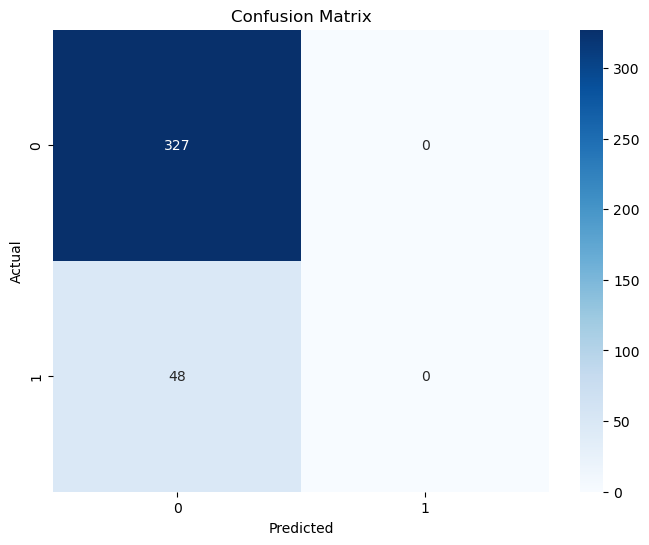

In [171]:
cm = confusion_matrix(Y_test, Y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=clf.classes_, yticklabels=clf.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()